In [10]:
import numpy as np
import matplotlib.pyplot as plt
import qutip
from scipy.linalg import expm
from scipy.constants import hbar
from IPython.display import clear_output

# Qubit evolution in the lab frame

Define the Pauli matrices

$\sigma_z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}$ $\sigma_x = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}$ $\sigma_y = \begin{pmatrix} 0 & -i \\ i & 0 \end{pmatrix}$

In [2]:
sigmaZ = np.array([[1,0],
                   [0,-1]])
sigmaX = np.array([[0,1],
                   [1,0]])
sigmaY = np.array([[0,-1j],
                   [1j,0]])

Define the Hamiltonian $\mathcal{H} = \frac{\hbar}{2} \omega \sigma_z$

In [3]:
omega = 2 * np.pi

H = hbar/2 * omega * sigmaZ
print(H)

[[ 3.31303507e-34  0.00000000e+00]
 [ 0.00000000e+00 -3.31303507e-34]]


Define an initial state $| \psi_0 \rangle = c_0 \begin{pmatrix} 1 \\ 0 \end{pmatrix} + c_1 \begin{pmatrix} 0 \\ 1 \end{pmatrix}$

In [4]:
#psi0 = np.array([1,0])
psi0 = np.array([1,1])*1/np.sqrt(2)
print(psi0)

[0.70710678 0.70710678]


Evolve the state in time using $| \psi_t \rangle = U(t) | \psi_0 \rangle$ with $U(t) = e^{\frac{-i H t}{\hbar}}$

In [5]:
time = np.linspace(0,0.95,96)
psiT = []

for t in time:
    psiT.append(expm(-1j*H*t/hbar) @ psi0)

Save the expectation values of x, y and z (e.g. $\langle \psi_t | \sigma_z | \psi_t \rangle$)

In [6]:
x = [(p.conj().T @ sigmaX @ p).real for p in psiT]
y = [(p.conj().T @ sigmaY @ p).real for p in psiT]
z = [(p.conj().T @ sigmaZ @ p).real for p in psiT]

Plot the evolution of the state

In [7]:
def qubitPlots(time,x,y,z):
    bsPlot = qutip.Bloch()
    bsPlot.add_points([x, y, z])
    bsPlot.render()
    bsPlot.fig.set_size_inches([25,5])

    ax1 = bsPlot.fig.add_subplot(133)
    ax1.plot(time,x,label="x")
    ax1.plot(time,y,label="y")
    ax1.plot(time,z,label="z")
    ax1.legend()
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Expectation value")
    
    bsPlot.show()

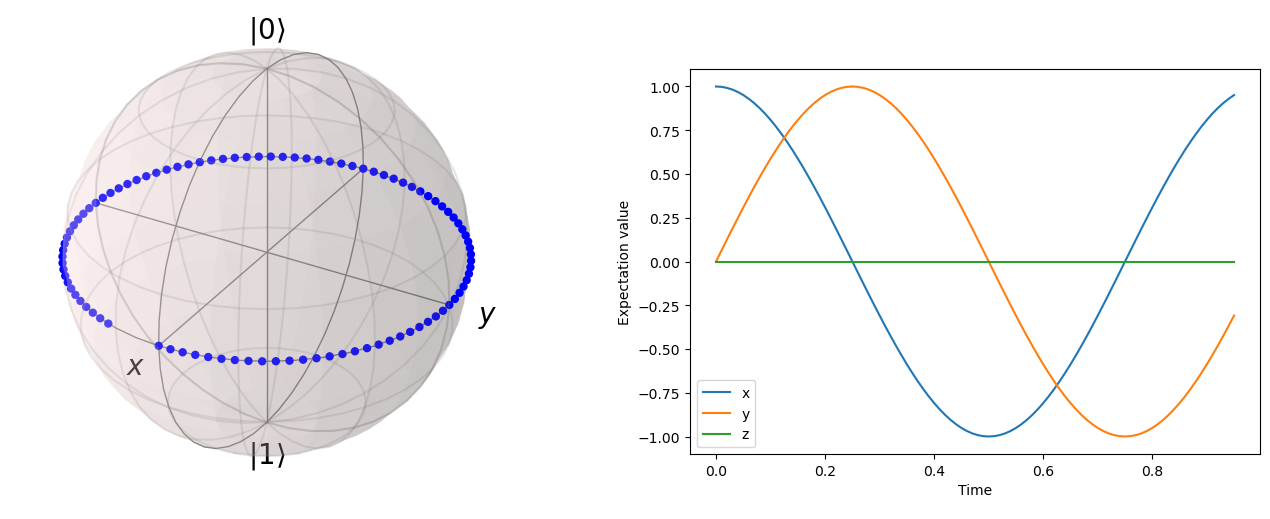

In [12]:
qubitPlots(time,x,y,z)
# clear_output()

# Qubit evolution in the rotating frame

Define the Hamiltonian $\mathcal{H} = \frac{\hbar}{2} ( \Delta \sigma_z + \Omega_x \sigma_x + \Omega_y \sigma_y )$

In [ ]:
delta = 0
omegaX = 2 * np.pi
omegaY = 0 * np.pi

H = hbar/2 * ( delta*sigmaZ + omegaX*sigmaX + omegaY*sigmaY )
print(H)

In [ ]:
psi0 = np.array([1,0])

dTime = 0.01
psiT = []

psiT.append(psi0)
for t in range(95):
    psiT.append(expm(-1j*H*dTime/hbar) @ psiT[-1])
    
x = [(p.conj().T @ sigmaX @ p).real for p in psiT]
y = [(p.conj().T @ sigmaY @ p).real for p in psiT]
z = [(p.conj().T @ sigmaZ @ p).real for p in psiT]

In [ ]:
qubitPlots(time,x,y,z)